# Classifying the language of the last name via LSTM

Repeat previous RNN exercise but with LSTM

## Support code

In [82]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
#from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [83]:
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

## Play with fake LSTM

In [84]:
input_features = 6
hidden_size = 3
n = 4
rnn = nn.LSTM(input_size=input_features, hidden_size=hidden_size, num_layers=1)
inputs = [torch.randn(1, input_features) for _ in range(n)] # make n vectors
inputs = torch.cat(inputs)
inputs

tensor([[ 1.7563, -1.3696,  0.8025, -0.2179,  0.4296,  0.5692],
        [ 0.3080, -0.3438,  0.7850, -0.5541,  1.2419,  0.4789],
        [-0.6685, -0.7192, -0.3011, -0.2866, -0.2973, -0.4047],
        [-0.1385,  0.0389,  0.1752, -2.0938,  0.0946, -1.3086]])

In [85]:
inputs = inputs.reshape(len(inputs), 1, input_features)
inputs

tensor([[[ 1.7563, -1.3696,  0.8025, -0.2179,  0.4296,  0.5692]],

        [[ 0.3080, -0.3438,  0.7850, -0.5541,  1.2419,  0.4789]],

        [[-0.6685, -0.7192, -0.3011, -0.2866, -0.2973, -0.4047]],

        [[-0.1385,  0.0389,  0.1752, -2.0938,  0.0946, -1.3086]]])

In [86]:
h0 = torch.zeros(1, 1, hidden_size)
c0 = torch.zeros(1, 1, hidden_size)

In [87]:
o, hc = rnn(inputs, (h0,c0))
# output is shape (n, max sequence length, hidden_size)
print(o.shape)
o

torch.Size([4, 1, 3])


tensor([[[-0.0173, -0.4704, -0.0694]],

        [[ 0.0161, -0.6711, -0.0637]],

        [[ 0.0702, -0.4553,  0.0381]],

        [[ 0.0327, -0.6640,  0.0249]]], grad_fn=<StackBackward>)

In [88]:
hc

(tensor([[[ 0.0327, -0.6640,  0.0249]]], grad_fn=<StackBackward>),
 tensor([[[ 0.0813, -1.0328,  0.0695]]], grad_fn=<StackBackward>))

## Load

Let's download [training](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_train.csv.gz) and [testing](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_test.csv.gz) data for last names.   This data set is a bunch of last names and the nationality or language. 

In [89]:
df_train = pd.read_csv("data/names_train.csv", header=None)
df_train.columns = ['name','language']
df_test = pd.read_csv("data/names_train.csv", header=None)
df_test.columns = ['name','language']

In [90]:
df_train.shape, df_test.shape

((13374, 2), (13374, 2))

In [91]:
df_train.head(2)

,name,language
0,Adsit,Czech
1,Ajdrna,Czech


## Clean

In [92]:
badname = df_train['name']=='To The First Page'
df_train[badname]

,name,language
8340,To The First Page,Russian
8341,To The First Page,Russian
8342,To The First Page,Russian
8343,To The First Page,Russian
8344,To The First Page,Russian
8345,To The First Page,Russian
8346,To The First Page,Russian
8347,To The First Page,Russian
8348,To The First Page,Russian
8349,To The First Page,Russian


In [93]:
comma = df_train['name'].str.contains(',') # might as well keep
df_train[comma]

,name,language
5976,"Jevolojnov,",Russian
6549,"Lytkin,",Russian


In [94]:
df_train[df_train['name'].str.contains("'")][:3] # there are ok so keep quote

,name,language
3609,Awak'Yan,Russian
4454,Dan'Ko,Russian
4471,Dar'Kin,Russian


In [95]:
badname = df_train['name']=='To The First Page'
df_train = df_train[~badname]

badname = df_test['name']=='To The First Page'
df_test = df_test[~badname]

In [96]:
df_train['name'] = df_train['name'].str.lower()
df_test['name'] = df_test['name'].str.lower()

In [97]:
def maxlen(strings:Sequence[str]) -> int:
    return max([len(l) for l in strings])

max_len = max(maxlen(df_train['name']), maxlen(df_test['name']))
max_len

19

## Split out validation set

In [98]:
X, y = df_train[['name']], df_train['language']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
X_test, y_test = df_test[['name']], df_test['language']

## Get vocab

In [99]:
def vocab(strings):
    letters = [list(l) for l in strings]
    V = set([c for cl in letters for c in cl])
    V = sorted(list(V))
    ctoi = {c:i for i, c in enumerate(V)}
    return V, ctoi

In [100]:
V, ctoi = vocab(X['name'])
ctoi

{' ': 0,
 "'": 1,
 ',': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

## Encode target language (class)

Get categories from training only, not valid/test sets. Then apply cats to those set y's.

In [101]:
y_train = y_train.astype('category').cat.as_ordered()
y_cats = y_train.cat.categories
y_cats

Index(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German',
       'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish',
       'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'],
      dtype='object')

In [102]:
y_train = y_train.cat.codes
y_train.values[:10]

array([ 2, 14,  4,  0, 10, 10,  5, 14,  0,  4], dtype=int8)

In [103]:
y_valid = pd.Categorical(y_valid, categories=y_cats, ordered=True).codes
y_test = pd.Categorical(y_test, categories=y_cats, ordered=True).codes

In [104]:
y_valid[:5], y_test[:5]

(array([14, 14, 14,  0, 14], dtype=int8), array([2, 2, 2, 2, 2], dtype=int8))

## One-hot encode each letter of each name

Each name becomes a matrix of size vocab_size x max_len. Each column represents a char and we pad with zeros out to max_len number of columns since tensors have to be same length in same dimension. 

This approach is wasteful in that it expands each word to len of longest but avoids having to pad explicitly, simplifying the training process.

In [105]:
def onehot(strings:Sequence[str], V, ctoi, max_len=None) -> torch.tensor:
    if max_len is None:
        max_len = maxlen(strings)
    X_onehot = torch.zeros(len(strings),len(V),max_len)
    for i,name in enumerate(strings):
        onehot = torch.zeros((len(V),max_len))
        for j,c in enumerate(name):
            onehot[ctoi[c],j] = 1
        X_onehot[i] = onehot
    return X_onehot

In [106]:
sample = ['cat','a','at'] # always debug with a small representative example
o = onehot(sample, *vocab(sample))
o

tensor([[[0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]]])

In [107]:
o[0,1].reshape(-1,1)

tensor([[1.],
        [0.],
        [0.]])

In [108]:
X_train_onehot = onehot(X_train['name'], V, ctoi, max_len=max_len).to(device)
X_train_onehot[0].shape

torch.Size([29, 19])

In [109]:
X_valid_onehot = onehot(X_valid['name'], V, ctoi, max_len=max_len).to(device)
X_valid_onehot[0].shape

torch.Size([29, 19])

## LSTM model

Previous shape is now wrong for LSTM:

In [110]:
X_train_onehot.shape

torch.Size([10686, 29, 19])

The input shape should be (num records, max name len, input features)

In [111]:
subset=10_000
X_train_onehot, y_train = X_train_onehot[:subset], torch.tensor(y_train[:subset].values).long()
X_valid_onehot, y_valid = X_valid_onehot[:subset], torch.tensor(y_valid[:subset]).long()
X_train_onehot = X_train_onehot.reshape(len(X_train_onehot), max_len, len(V))
X_valid_onehot = X_valid_onehot.reshape(len(X_valid_onehot), max_len, len(V))
X_train_onehot.shape

torch.Size([10000, 19, 29])

In [112]:
class LastNameLSTM(nn.Module):
    def __init__(self, input_features, hidden_size, output_size):
        super(LastNameLSTM, self).__init__()
#         print("Model: ",input_features, hidden_size, output_size)
        self.input_features = input_features
        self.hidden_size = hidden_size
        self.output_size = output_size
        # combine W and U into W then cat h and input
        self.lstm = nn.LSTM(input_size=input_features,
                            hidden_size=hidden_size,
                            num_layers=1,
                            batch_first=True)
        self.V  = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
#         print("X", X.shape)
        batch_size = X.shape[0]
        max_len = X.shape[1]
        # LSTMs need hidden and state vectors, one per input symbol
        # also this resets h, c for each batch, not sure that is good
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        h, c = h0, c0
        
        # output is shape (batch size, max_len, hidden_size)
        o, (h,c) = self.lstm(X, (h,c))
#         print(h.shape, c.shape) # [1, 19, 50]   [1, 19, 50]
#         print("lstm o", o.shape)
        # o has ALL outputs, for each step as it works through chars of name.
        # We only need the last output, which we run into final layer
        # for classification
        o = o[:,-1,:]
#         print("last output", o.shape)
        o = self.V(o)
        o = self.softmax(o)
#         print("final layer", o.shape)
        return o

In [113]:
def ctrain(model:nn.Module, train_data:TensorDataset, valid_data:TensorDataset,
            epochs=350,
            test_size=0.20,
            learning_rate = 0.002,
            batch_size=32,
            weight_decay=1.e-4,
            loss_fn=F.cross_entropy,
            metric=accuracy_score,
            print_every=30):
    "Train a regressor"
    history = []
    train_loader = DataLoader(train_data, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for ei in range(epochs): # epochs
        for bi, (batch_x, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_prob = model(batch_x)
#             print("y_prob", y_prob.shape)
#             print("y pred", y_prob, "batch_y", batch_y)
            loss = loss_fn(y_prob, batch_y)

            optimizer.zero_grad()
            loss.backward() # autograd computes U.grad and M.grad
            optimizer.step()

        with torch.no_grad():
            loss        = loss_fn(model(train_data.tensors[0]), train_data.tensors[1])
            loss_valid  = loss_fn(model(valid_data.tensors[0]), valid_data.tensors[1])
            y_prob = model(train_data.tensors[0])
#             print("y_prob", y_prob.shape)
#             y_prob = F.softmax(y_prob, dim=1)
#             print("y_prob", y_prob)
            y_pred = torch.argmax(y_prob, dim=1)
#             print("y_pred", y_pred)
            metric_train = metric(y_pred.cpu(), train_data.tensors[1].cpu())
            y_prob = model(valid_data.tensors[0])
#             y_prob = F.softmax(y_prob, dim=1)
            y_pred = torch.argmax(y_prob, dim=1)
            metric_valid = metric(y_pred.cpu(), valid_data.tensors[1].cpu())

        history.append( (loss, loss_valid) )
        if ei % print_every == 0:
            print(f"Epoch {ei:3d} loss {loss:7.4f}, {loss_valid:7.4f}   {metric.__class__.__name__} {metric_train:4.3f}, {metric_valid:4.3f}")

    history = torch.tensor(history)
    return model, history

Epoch   0 loss  1.8364,  1.8681   function 0.471, 0.457
Epoch   4 loss  1.4803,  1.5285   function 0.547, 0.534
Epoch   8 loss  1.3094,  1.3676   function 0.632, 0.612
Epoch  12 loss  1.2019,  1.2867   function 0.666, 0.635
Epoch  16 loss  1.1649,  1.2580   function 0.674, 0.642
Epoch  20 loss  1.1239,  1.2348   function 0.683, 0.651
Epoch  24 loss  1.0480,  1.1652   function 0.697, 0.667
Epoch  28 loss  1.0299,  1.1580   function 0.698, 0.668
Epoch  32 loss  0.9970,  1.1302   function 0.707, 0.667
Epoch  36 loss  0.9451,  1.1095   function 0.719, 0.679


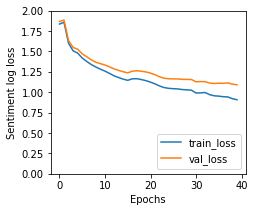

In [134]:
rnn = LastNameLSTM(input_features=len(V),
                   hidden_size=50,
                   output_size=len(y_cats))
rnn = rnn.to(device)

# X input shape (max name len, num records, input features)
train = TensorDataset(X_train_onehot.to(device), y_train.to(device))
valid = TensorDataset(X_valid_onehot.to(device), y_valid.to(device))
model, history = ctrain(rnn, train, valid,
#                         loss_fn=torch.nn.CrossEntropyLoss(),
                        loss_fn=torch.nn.NLLLoss(),
#                         loss_fn=F.cross_entropy,
                        metric=accuracy_score,
                        epochs=40,
                        learning_rate=0.003,
                        weight_decay=0.001,
                        batch_size=64,  
                        print_every=4)

plot_history(history, yrange=(0,2))